<a href="https://colab.research.google.com/github/Karthikamantharasalam/PNEUMONIA_DETECTION_WITH_CNN/blob/main/Copy_of_PNEUMONIADETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O

# Input data files are available in the "../input/" directory.
# For example, running this will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/dataset/chest_xray/chest_xray'):
    for filename in filenames:
       # print(os.path.join(dirname, filename))
        pass
    print(dirname)



# Any results you write to the current directory are saved as output.

/content/drive/MyDrive/dataset/chest_xray/chest_xray
/content/drive/MyDrive/dataset/chest_xray/chest_xray/train
/content/drive/MyDrive/dataset/chest_xray/chest_xray/train/NORMAL
/content/drive/MyDrive/dataset/chest_xray/chest_xray/train/PNEUMONIA
/content/drive/MyDrive/dataset/chest_xray/chest_xray/val
/content/drive/MyDrive/dataset/chest_xray/chest_xray/val/NORMAL
/content/drive/MyDrive/dataset/chest_xray/chest_xray/val/PNEUMONIA
/content/drive/MyDrive/dataset/chest_xray/chest_xray/test
/content/drive/MyDrive/dataset/chest_xray/chest_xray/test/NORMAL
/content/drive/MyDrive/dataset/chest_xray/chest_xray/test/PNEUMONIA


In [ ]:
#importing necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np #Added import for numpy

In [ ]:
#labelling the data
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)

    return np.array(data, dtype=object) # Modified to handle varying shapes

In [ ]:
train = get_training_data('/content/drive/MyDrive/dataset/chest_xray/chest_xray/train')
test = get_training_data('/content/drive/MyDrive/dataset/chest_xray/chest_xray/test')
val = get_training_data('/content/drive/MyDrive/dataset/chest_xray/chest_xray/val')

In [ ]:
#Data Visualization & Preprocessing
l=[]
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)
#The data seems imbalanced .
print("Train",len(train))
print("Test",len(test))
print("Val",len(val))
#To increase the no. of training examples, we will use data augmentation

NameError: name 'train' is not defined

Text(0.5, 1.0, 'NORMAL')

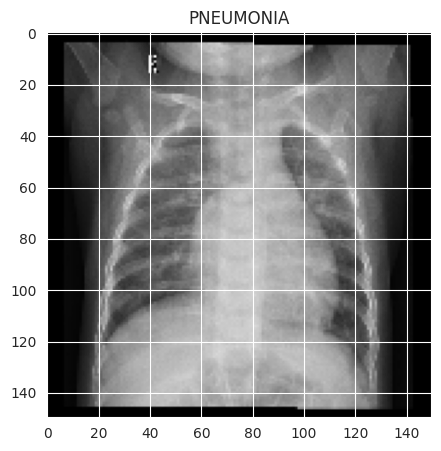

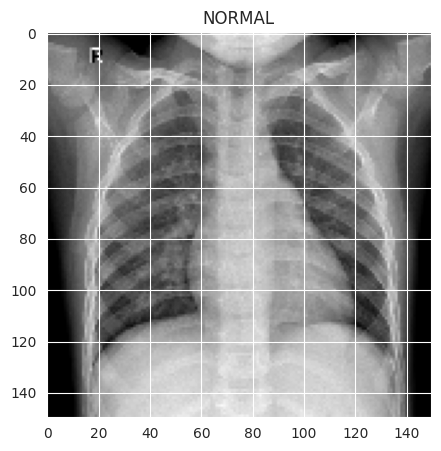

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])


In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)
print("x_train",len(x_train))
print("x_test",len(x_test))
print("x_val",len(x_val))


x_train 5226
x_test 624
x_val 16


In [ ]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

print("x_train",x_train.shape)
print("x_test",x_test.shape)
print("x_val",x_val.shape)

x_train (5226, 150, 150)
x_test (624, 150, 150)
x_val (16, 150, 150)


In [ ]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)


In [ ]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

For the data augmentation :

Randomly rotate some training images by 30 degrees
Randomly Zoom by 20% some training images
Randomly shift images horizontally by 10% of the width
Randomly shift images vertically by 10% of the height
Randomly flip images horizontally. Once our model is ready, we fit the training dataset

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(150, 150, 1)))  # Use input_shape here
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 38, 38, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 38, 38, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 19, 19, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 10, 10, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6400)                │              

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [ ]:
learning_rate_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=1,factor=0.3,min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 10, validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


164/164 ━━━━━━━━━━━━━━━━━━━━ 441s 3s/step - accuracy: 0.7836 - loss: 1.1906 - val_accuracy: 0.5000 - val_loss: 36.1269 - learning_rate: 0.0010
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 438s 3s/step - accuracy: 0.9015 - loss: 0.2660 - val_accuracy: 0.5000 - val_loss: 18.3273 - learning_rate: 0.0010
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 430s 3s/step - accuracy: 0.9195 - loss: 0.2154 - val_accuracy: 0.5625 - val_loss: 10.9561 - learning_rate: 0.0010
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 449s 3s/step - accuracy: 0.9274 - loss: 0.2061 - val_accuracy: 0.5625 - val_loss: 3.5655 - learning_rate: 0.0010
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9340 - loss: 0.1732
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
164/164 ━━━━━━━━━━━━━━━━━━━━ 443s 3s/step - accuracy: 0.9340 - loss: 0.1734 - val_accuracy: 0.5625 - val_loss: 1.3608 - learning_rate: 0.0010
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 433s 3s/step - accuracy: 0.9522 - loss: 0.1433 - val_

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 483ms/step - accuracy: 0.9370 - loss: 0.2028
Loss of the model is -  0.36017170548439026
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 414ms/step - accuracy: 0.9370 - loss: 0.2028
Accuracy of the model is -  91.82692170143127 %


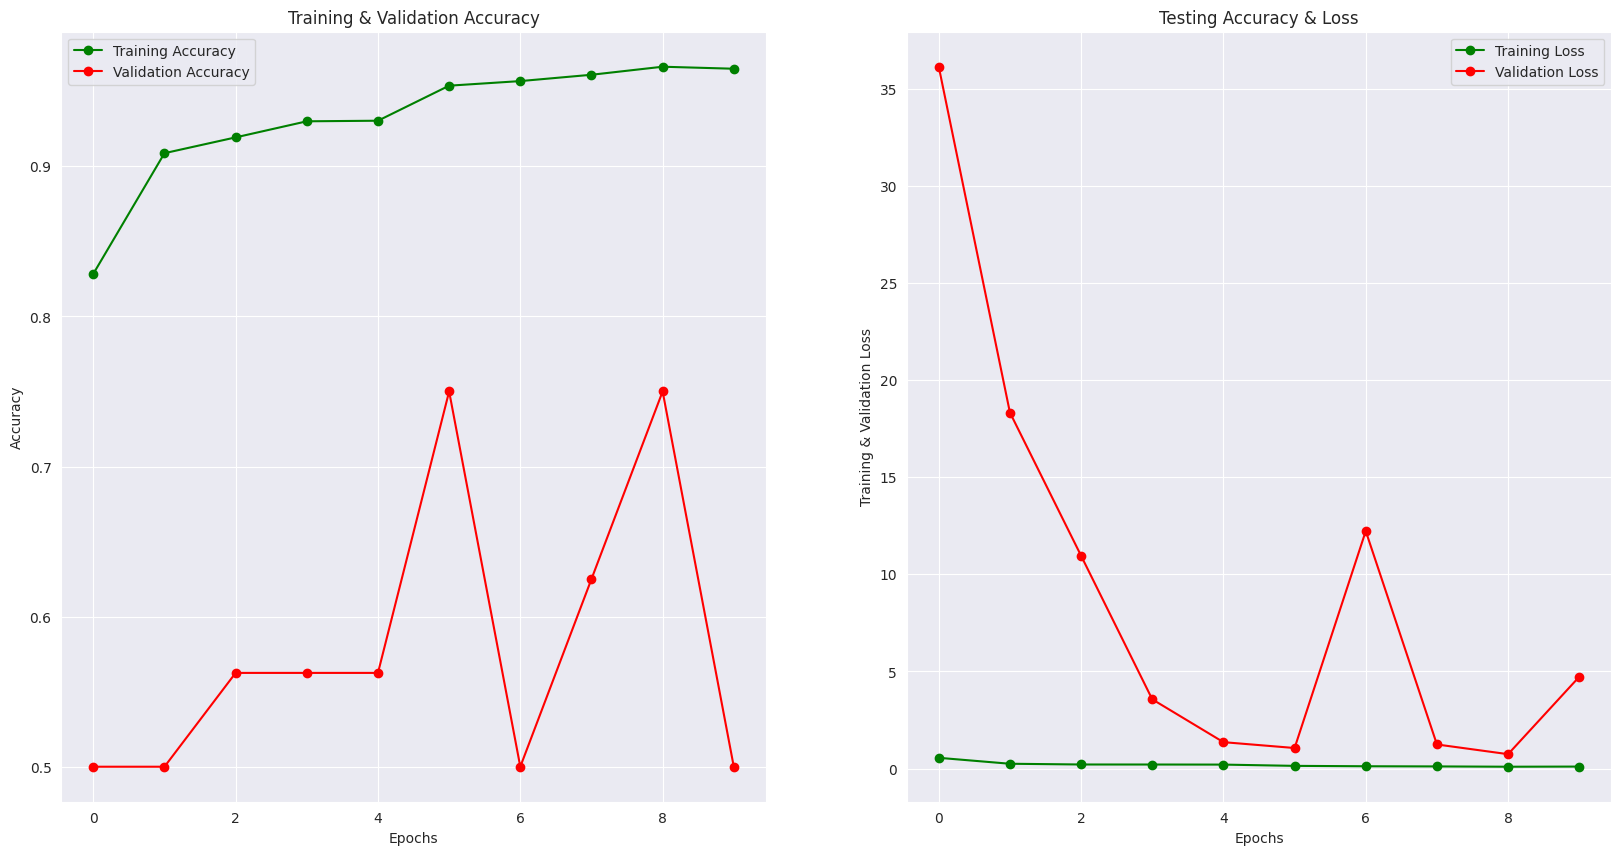

In [ ]:
epochs = [i for i in range(len(history.history['accuracy']))]  # Adjust epochs to match training history length
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 487ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.91      0.96      0.94       390
   Normal (Class 1)       0.93      0.85      0.89       234

           accuracy                           0.92       624
          macro avg       0.92      0.90      0.91       624
       weighted avg       0.92      0.92      0.92       624



In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

array([[374,  16],
       [ 35, 199]])

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

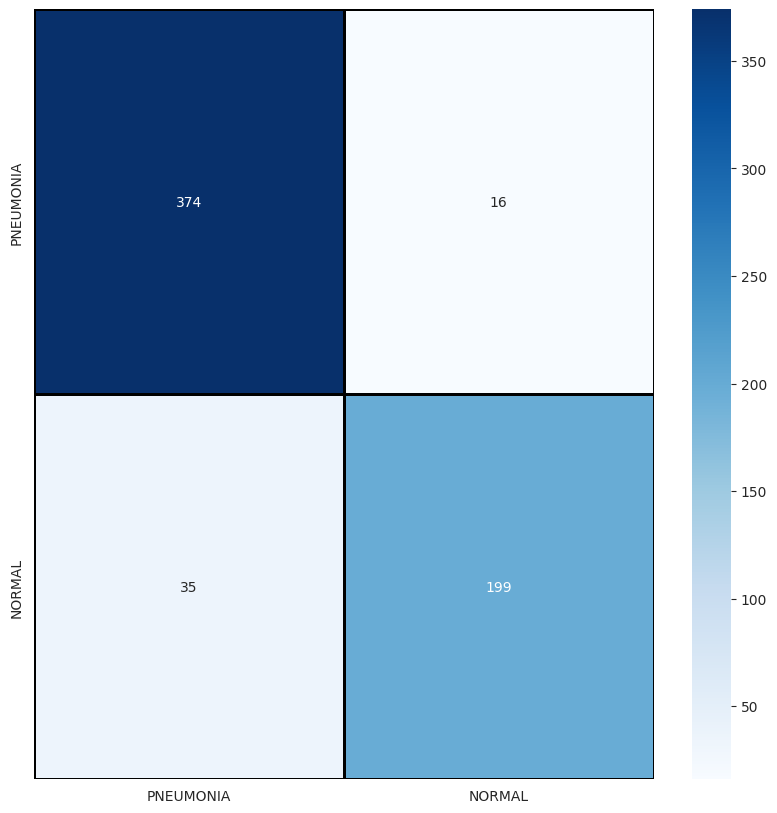

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

<ipython-input-35-3b0e8ec19e68>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


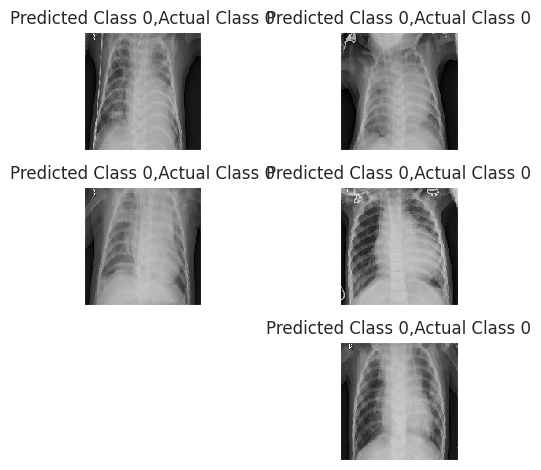

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

<ipython-input-36-d863d2b73908>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


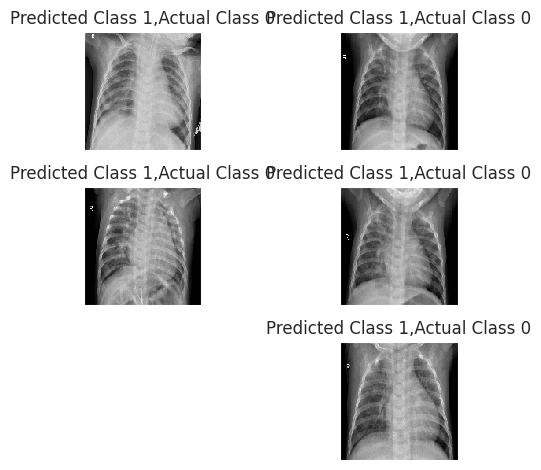

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

In [ ]:
import os
model.save('/content/drive/MyDrive/dataset/pneumoniadummy.keras')


In [ ]:
!pip install Flask pyngrok scikit-learn pandas matplotlib seaborn colorama
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from flask import Flask, render_template, request, redirect, url_for
from pyngrok import ngrok
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

In [ ]:
!ngrok config add-authtoken 2kpb3kKOWdonaYwLF6xgx8N7GMo_3d1MD6KzPiviwWi4PFpW1

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!pip install PyMySQL
import pymysql
connection = pymysql.connect(
        host='your-cloud-sql-instance',
        user='your-username',
        password='your-password',
        database='your-database-name'
    )

    # Use the connection to execute queries
with connection.cursor() as cursor:
        cursor.execute("SELECT * FROM your_table")
        result = cursor.fetchall()
        print(result)

connection.close()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 1.2 MB/s eta 0:00:00


OperationalError: (2003, "Can't connect to MySQL server on 'your-cloud-sql-instance' ([Errno -2] Name or service not known)")

In [ ]:
import sqlite3

    # Connect to a database (creates a new one if it doesn't exist)
    connection = sqlite3.connect('your_database.db')

    # Create a table
    with connection.cursor() as cursor:
        cursor.execute("CREATE TABLE IF NOT EXISTS your_table (id INTEGER PRIMARY KEY, name TEXT)")

    # Insert data
    with connection.cursor() as cursor:
        cursor.execute("INSERT INTO your_table (name) VALUES (?)", ('Your Name',))
        connection.commit()

    # Query data
    with connection.cursor() as cursor:
        cursor.execute("SELECT * FROM your_table")
        result = cursor.fetchall()
        print(result)

    connection.close()

In [ ]:
from google.colab import drive
    drive.mount('/content/drive')

    # Connect to the database in your Drive
    connection = sqlite3.connect('/content/drive/MyDrive/your_database.db')
    # ... (rest of your database operations) ...

In [ ]:
!pip install flask werkzeug numpy opencv-python tensorflow pyngrok


In [ ]:
%%writefile app.py
from flask import Flask, request, render_template_string
from werkzeug.utils import secure_filename
import os
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from pyngrok import ngrok

app = Flask(__name__)
app.secret_key = '12345'
app.config['UPLOAD_FOLDER'] = 'static/uploads/'
app.config['ALLOWED_EXTENSIONS'] = {'png', 'jpg', 'jpeg'}

login_manager = LoginManager()
login_manager.init_app(app)
login_manager.login_view = 'login'

# Load your trained model
model = load_model('/content/drive/MyDrive/dataset/pneumoniadummy.keras')  # Replace with your model file path

def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in app.config['ALLOWED_EXTENSIONS']



def predict_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (150, 150))
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    return 'Pneumonia' if prediction[0] > 0.5 else 'Normal'

@app.route('/')
def index():
    return '''
   <!DOCTYPE html>
<html>
<head>
    <title>Pneumonia Detection</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            margin: 0;
            padding: 0;
            display: flex;
            flex-direction: column;
            align-items: center;
            justify-content: center;
            height: 100vh;
            background-color: #e6f7f5; /* Soft teal background */
        }
        .container {
            background: white;
            padding: 20px;
            border-radius: 10px;
            box-shadow: 0 4px 8px rgba(0,0,0,0.1);
            width: 80%;
            max-width: 600px;
            text-align: center;
        }
        .container h1 {
            margin-bottom: 20px;
            color: #00695c; /* Dark teal for headings */
        }
        .form-box {
            display: flex;
            flex-direction: column;
            gap: 10px;
            padding: 10px;
            border: 1px solid #ddd;
            border-radius: 5px;
            margin: 10px 0;
            transition: background-color 0.3s ease;
        }
        .form-box:hover {
            background-color: #e0f2f1; /* Light teal hover effect */
        }
        .form-box label {
            font-weight: bold;
            color: #004d40; /* Darker teal for labels */
        }
        .form-box input, .form-box select {
            padding: 10px;
            border: 1px solid #ccc;
            border-radius: 5px;
            color: #004d40; /* Darker teal for input text */
        }
        .form-box input[type="submit"] {
            background-color: #00695c; /* Dark teal background */
            color: white;
            cursor: pointer;
            transition: background-color 0.3s ease;
        }
        .form-box input[type="submit"]:hover {
            background-color: #004d40; /* Darker teal hover effect */
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Pneumonia Detection - Machine Learning Model</h1>
        <form class="form-box" action="/predict" method="post" enctype="multipart/form-data">
            <label for="name">Patient Name:</label>
            <input type="text" id="name" name="name" required placeholder="Enter patient name"><br>
            <label for="age">Age:</label>
            <input type="number" id="age" name="age" required placeholder="Enter age" min="0"><br>
            <label for="sex">Sex:</label>
            <select id="sex" name="sex" required>
                <option value="Male">Male</option>
                <option value="Female">Female</option>
            </select><br>
            <label for="weight">Weight (kg):</label>
            <input type="number" id="weight" name="weight" required placeholder="Enter weight" min="0" step="0.1"><br>
            <label for="file">Upload Chest X-ray Image:</label>
            <input type="file" id="file" name="file" accept=".png, .jpg, .jpeg" required><br>
            <input type="submit" value="Predict">
        </form>
    </div>
</body>
</html>

    '''

@app.route('/predict', methods=['POST'])
def predict():
    name = request.form['name']
    age = request.form['age']
    sex = request.form['sex']
    weight = request.form['weight']
    file = request.files['file']

    if file and allowed_file(file.filename):
        filename = secure_filename(file.filename)
        file_path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
        file.save(file_path)

        result = predict_image(file_path)
        return f'''
        <!DOCTYPE html>
        <html>
        <head>
            <title>Prediction Result</title>
            <style>
                body {{
                    font-family: Arial, sans-serif;
                    margin: 0;
                    padding: 0;
                    display: flex;
                    flex-direction: column;
                    align-items: center;
                    justify-content: center;
                    height: 100vh;
                    background-color: #e6f7f5; /* Soft teal background */
                }}
                .container {{
                    background: white;
                    padding: 20px;
                    border-radius: 10px;
                    box-shadow: 0 4px 8px rgba(0,0,0,0.1);
                    width: 80%;
                    max-width: 600px;
                    text-align: center;
                }}
                .container h1 {{
                    margin-bottom: 20px;
                    color: #00695c; /* Dark teal for headings */
                }}
                .info-box {{
                    display: flex;
                    justify-content: space-between;
                    align-items: center;
                    padding: 10px;
                    border: 1px solid #ddd;
                    border-radius: 5px;
                    margin: 10px 0;
                    transition: background-color 0.3s ease;
                }}
                .info-box:hover {{
                    background-color: #e0f2f1; /* Light teal hover effect */
                }}
                .info-box label {{
                    font-weight: bold;
                    color: #004d40; /* Darker teal for labels */
                }}
                .info-box p {{
                    margin: 0;
                    color: #004d40; /* Darker teal for text */
                }}
                .image-box {{
                    margin: 20px 0;
                }}
                .image-box img {{
                    max-width: 100%;
                    border-radius: 10px;
                }}
                .back-link {{
                    display: inline-block;
                    margin-top: 20px;
                    padding: 10px 20px;
                    text-decoration: none;
                    color: white;
                    background-color: #00695c; /* Dark teal background */
                    border-radius: 5px;
                    transition: background-color 0.3s ease;
                }}
                .back-link:hover {{
                    background-color: #004d40; /* Darker teal hover effect */
                }}
            </style>
        </head>
        <body>
            <div class="container">
                <h1>Prediction Result</h1>
                <div class="info-box">
                    <label>Patient Name:</label>
                    <p>{name}</p>
                </div>
                <div class="info-box">
                    <label>Age:</label>
                    <p>{age}</p>
                </div>
                <div class="info-box">
                    <label>Sex:</label>
                    <p>{sex}</p>
                </div>
                <div class="info-box">
                    <label>Weight:</label>
                    <p>{weight} kg</p>
                </div>
                <div class="info-box">
                    <label>Model Output:</label>
                    <p>The chest X-ray image is predicted to be {result}.</p>
                </div>
                <div class="image-box">
                    <img src="{file_path}" alt="Chest X-ray Image">
                </div>
                <a class="back-link" href="/">Back to Home</a>
            </div>
        </body>
        </html>
        '''
    return "File type not allowed"

if __name__ == '__main__':
    # Open an ngrok tunnel to the HTTP server
    url = ngrok.connect(5000)
    print(' * Tunnel URL:', url)

    app.run(port=5000)


Writing app.py


In [ ]:
import os
if not os.path.exists('static/uploads'):
    os.makedirs('static/uploads')


In [ ]:
from google.colab import files
uploaded = files.upload()


In [ ]:
!python3 app.py


In [ ]:
!pip install Flask-Login

In [ ]:
from flask import Flask, request, render_template_string, redirect, url_for
# ... other imports ...
from flask_login import LoginManager, UserMixin, login_user, logout_user, login_required, current_user

app = Flask(__name__)
# ... other app configurations ...
app.secret_key = 'your_secret_key'  # Replace with a strong secret key

login_manager = LoginManager()
login_manager.init_app(app)
login_manager.login_view = 'login'  # Redirect to login page if not authenticated

# User model (replace with your actual user database logic)
class User(UserMixin):
    def __init__(self, id, username, password):
        self.id = id
        self.username = username
        self.password = password

# Sample user database (replace with a real database)
users = {
    1: User(1, 'user1', 'password'),
    2: User(2, 'user2', 'password'),
}

@login_manager.user_loader
def load_user(user_id):
    return users.get(int(user_id))

# Login route
@app.route('/login', methods=['GET', 'POST'])
def login():
    if request.method == 'POST':
        username = request.form['username']
        password = request.form['password']
        user = None
        for u in users.values():
            if u.username == username and u.password == password:
                user = u
                break
        if user:
            login_user(user)
            return redirect(url_for('index'))
        else:
            return 'Invalid username or password'
    return '''
        <form method="post">
            <p>Username: <input type="text" name="username"></p>
            <p>Password: <input type="password" name="password"></p>
            <p><input type="submit" value="Login"></p>
        </form>
    '''

# Signup route
@app.route('/signup', methods=['GET', 'POST'])
def signup():
    if request.method == 'POST':
        # Add logic to create a new user in your database
        return redirect(url_for('login'))
    return '''
        <form method="post">
            <p>Username: <input type="text" name="username"></p>
            <p>Password: <input type="password" name="password"></p>
            <p><input type="submit" value="Signup"></p>
        </form>
    '''

# Logout route
@app.route('/logout')
@login_required
def logout():
    logout_user()
    return redirect(url_for('index'))

# Protect the prediction route with login_required
@app.route('/predict', methods=['POST'])
@login_required
def predict():
    # ... your existing prediction logic ...

if __name__ == '__main__':
    # ... your existing app run logic ...